In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to fetch cryptocurrency data from Yahoo Finance using yfinance
def get_crypto_data(symbol, start_date, end_date):
    crypto_data = yf.download(symbol, start=start_date, end=end_date)
    return crypto_data

# Example usage
crypto_symbol = "BTC-USD"  # Use the appropriate symbol for the cryptocurrency
crypto_start_date = "2020-01-01"
crypto_end_date = "2024-01-31"

crypto_data = get_crypto_data(crypto_symbol, crypto_start_date, crypto_end_date)


[*********************100%%**********************]  1 of 1 completed


In [27]:
# Extract the closing prices
closing_prices = crypto_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

In [28]:
# Create training dataset
train_size = int(len(closing_prices_scaled) * 0.80)
train_data, test_data = closing_prices_scaled[0:train_size, :], closing_prices_scaled[train_size:len(closing_prices_scaled), :]

def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 60  # You can adjust this based on your needs
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [29]:
# Reshape data for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [30]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
36/36 [==============================] - 6s 73ms/step - loss: 0.0315
Epoch 2/10
36/36 [==============================] - 2s 53ms/step - loss: 0.0035
Epoch 3/10
36/36 [==============================] - 2s 49ms/step - loss: 0.0026
Epoch 4/10
36/36 [==============================] - 2s 48ms/step - loss: 0.0025
Epoch 5/10
36/36 [==============================] - 2s 49ms/step - loss: 0.0023
Epoch 6/10
36/36 [==============================] - 2s 50ms/step - loss: 0.0021
Epoch 7/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0020
Epoch 8/10
36/36 [==============================] - 2s 67ms/step - loss: 0.0018
Epoch 9/10
36/36 [==============================] - 2s 49ms/step - loss: 0.0017
Epoch 10/10
36/36 [==============================] - 2s 52ms/step - loss: 0.0016


In [32]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8/8 [==============================] - 0s 15ms/step


In [33]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

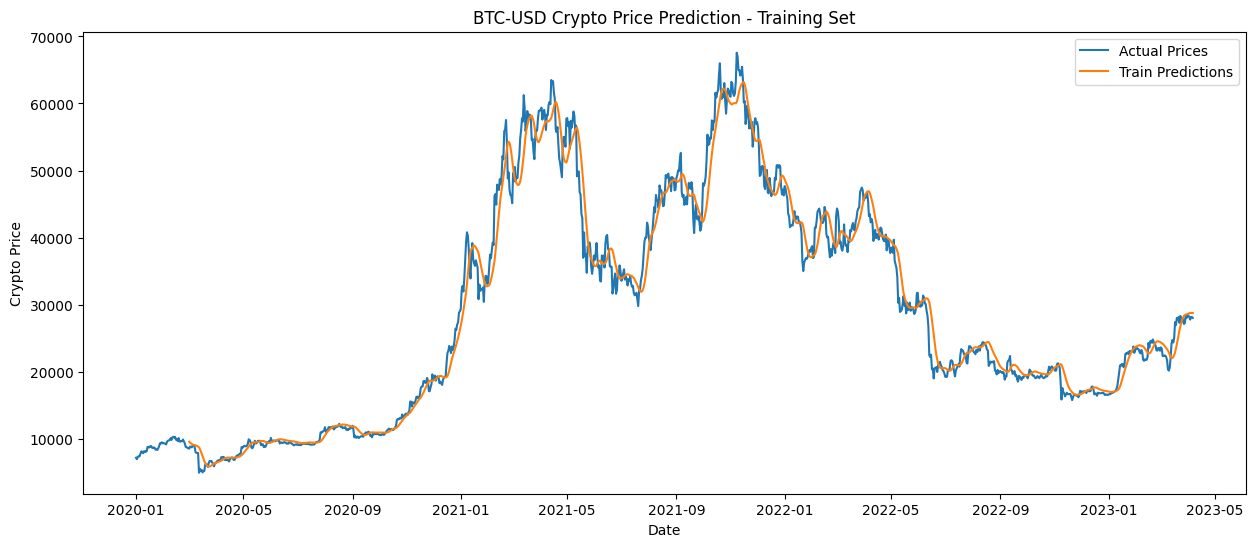

In [34]:
# Plot training set
plt.figure(figsize=(15, 6))
plt.plot(crypto_data.index[:train_size], closing_prices[:train_size], label='Actual Prices')
plt.plot(crypto_data.index[time_steps:train_size], train_predict, label='Train Predictions')
plt.title(f'{crypto_symbol} Crypto Price Prediction - Training Set')
plt.xlabel('Date')
plt.ylabel('Crypto Price')
plt.legend()
plt.show()

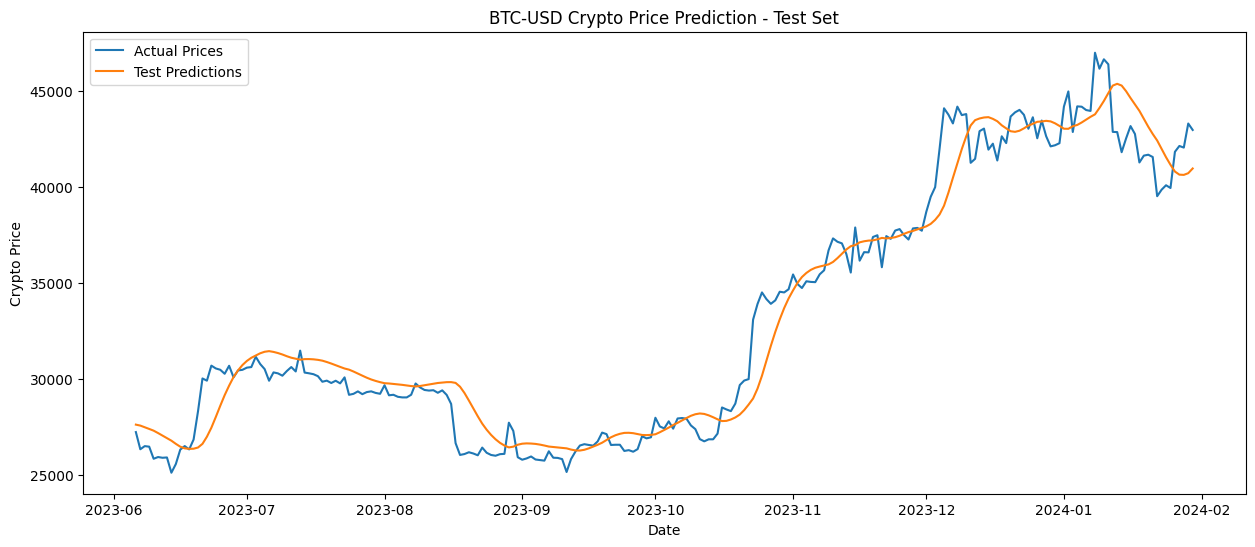

In [35]:
# Plot test set
plt.figure(figsize=(15, 6))
plt.plot(crypto_data.index[train_size + time_steps:], closing_prices[train_size + time_steps:], label='Actual Prices')
plt.plot(crypto_data.index[train_size + time_steps:], test_predict, label='Test Predictions')
plt.title(f'{crypto_symbol} Crypto Price Prediction - Test Set')
plt.xlabel('Date')
plt.ylabel('Crypto Price')
plt.legend()
plt.show()

In [36]:
# Extend the time frame to include future dates
end_date_future = "2024-12-31"
crypto_data_future = yf.download(crypto_symbol, start=crypto_start_date, end=end_date_future)

# Extract the closing prices
closing_prices_future = crypto_data_future['Close'].values.reshape(-1, 1)

# Normalize the future data using the same scaler
closing_prices_future_scaled = scaler.transform(closing_prices_future)

# Create the extended training dataset
train_data_extended = np.concatenate((closing_prices_scaled, closing_prices_future_scaled), axis=0)

# Create the extended time series data for training
X_train_extended, y_train_extended = create_dataset(train_data_extended, time_steps)

[*********************100%%**********************]  1 of 1 completed


In [37]:
# Reshape data for LSTM input
X_train_extended = X_train_extended.reshape(X_train_extended.shape[0], X_train_extended.shape[1], 1)

# Build the LSTM model
model_extended = Sequential()
model_extended.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_extended.shape[1], 1)))
model_extended.add(LSTM(units=50))
model_extended.add(Dense(units=1))
model_extended.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
# Train the model on the extended dataset
model_extended.fit(X_train_extended, y_train_extended, epochs=10, batch_size=32)

# Make predictions for the future
future_time_steps = 250  # Adjust as needed
X_future = closing_prices_future_scaled[-time_steps:].reshape(1, -1)

future_predictions = []

for i in range(future_time_steps):
    prediction = model_extended.predict(X_future.reshape(1, time_steps, 1))
    future_predictions.append(prediction[0, 0])
    X_future = np.append(X_future[0, 1:], prediction[0]).reshape(1, -1)

Epoch 1/10
92/92 [==============================] - 11s 65ms/step - loss: 0.0131
Epoch 2/10
92/92 [==============================] - 6s 61ms/step - loss: 0.0025
Epoch 3/10
92/92 [==============================] - 5s 50ms/step - loss: 0.0022
Epoch 4/10
92/92 [==============================] - 5s 55ms/step - loss: 0.0018
Epoch 5/10
92/92 [==============================] - 5s 55ms/step - loss: 0.0016
Epoch 6/10
92/92 [==============================] - 5s 50ms/step - loss: 0.0013
Epoch 7/10
92/92 [==============================] - 6s 61ms/step - loss: 0.0013
Epoch 8/10
92/92 [==============================] - 5s 49ms/step - loss: 0.0012
Epoch 9/10
92/92 [==============================] - 5s 55ms/step - loss: 0.0010
Epoch 10/10
1/1 [==============================] - 0s 29ms/step


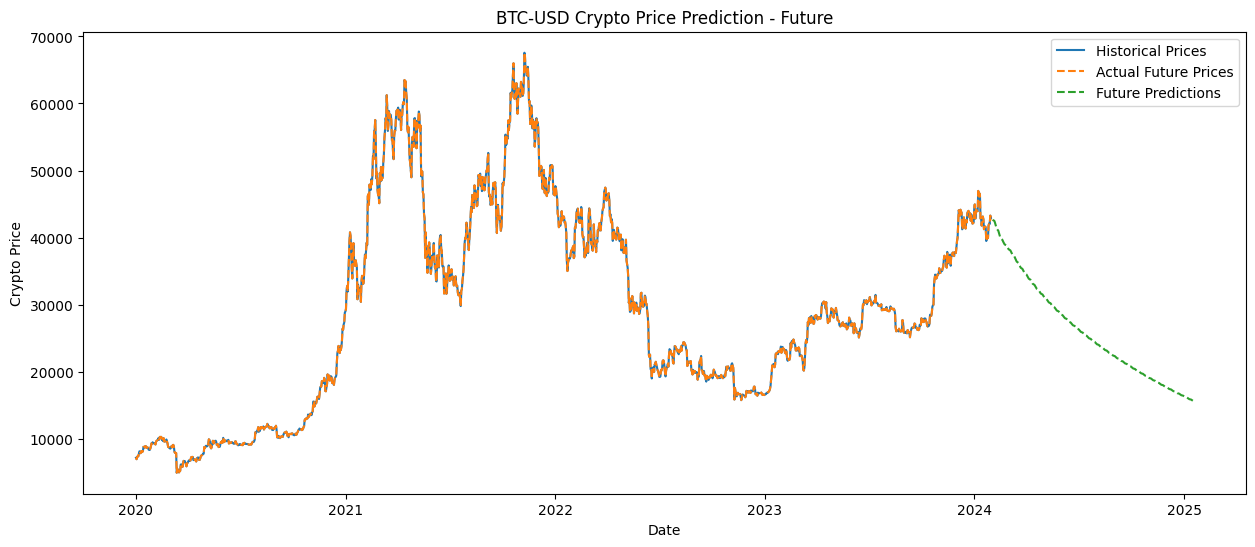

In [39]:
# Invert predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot future predictions
plt.figure(figsize=(15, 6))
plt.plot(crypto_data.index, closing_prices, label='Historical Prices')
plt.plot(crypto_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=crypto_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')
plt.title(f'{crypto_symbol} Crypto Price Prediction - Future')
plt.xlabel('Date')
plt.ylabel('Crypto Price')
plt.legend()
plt.show()

In [40]:
# Calculate short-term and long-term moving averages
short_window = 10
long_window = 90

crypto_data['Short_MA'] = crypto_data['Close'].rolling(window=short_window).mean()
crypto_data['Long_MA'] = crypto_data['Close'].rolling(window=long_window).mean()

# Generate buy/sell signals based on moving average crossovers
crypto_data['Signal'] = 0  # 0 represents no signal
crypto_data['Signal'][short_window:] = np.where(crypto_data['Short_MA'][short_window:] > crypto_data['Long_MA'][short_window:], 1, 0)
crypto_data['Position'] = crypto_data['Signal'].diff()

<ipython-input-40-0d18f5b966bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_data['Signal'][short_window:] = np.where(crypto_data['Short_MA'][short_window:] > crypto_data['Long_MA'][short_window:], 1, 0)


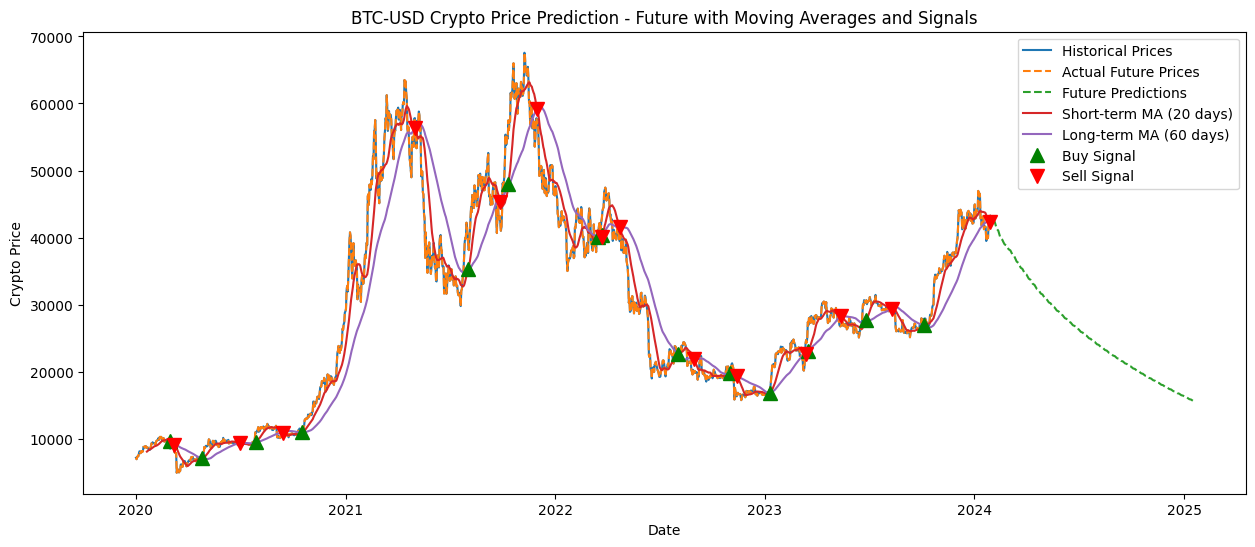

In [41]:
# Plot future predictions along with moving averages and signals
plt.figure(figsize=(15, 6))
plt.plot(crypto_data.index, closing_prices, label='Historical Prices')
plt.plot(crypto_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=crypto_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')
plt.plot(crypto_data.index, crypto_data['Short_MA'], label=f'Short-term MA ({short_window} days)')
plt.plot(crypto_data.index, crypto_data['Long_MA'], label=f'Long-term MA ({long_window} days)')

# Plot buy signals (green) and sell signals (red)
plt.plot(crypto_data[crypto_data['Position'] == 1].index, crypto_data['Short_MA'][crypto_data['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(crypto_data[crypto_data['Position'] == -1].index, crypto_data['Short_MA'][crypto_data['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')

plt.title(f'{crypto_symbol} Crypto Price Prediction - Future with Moving Averages and Signals')
plt.xlabel('Date')
plt.ylabel('Crypto Price')
plt.legend()
plt.show()

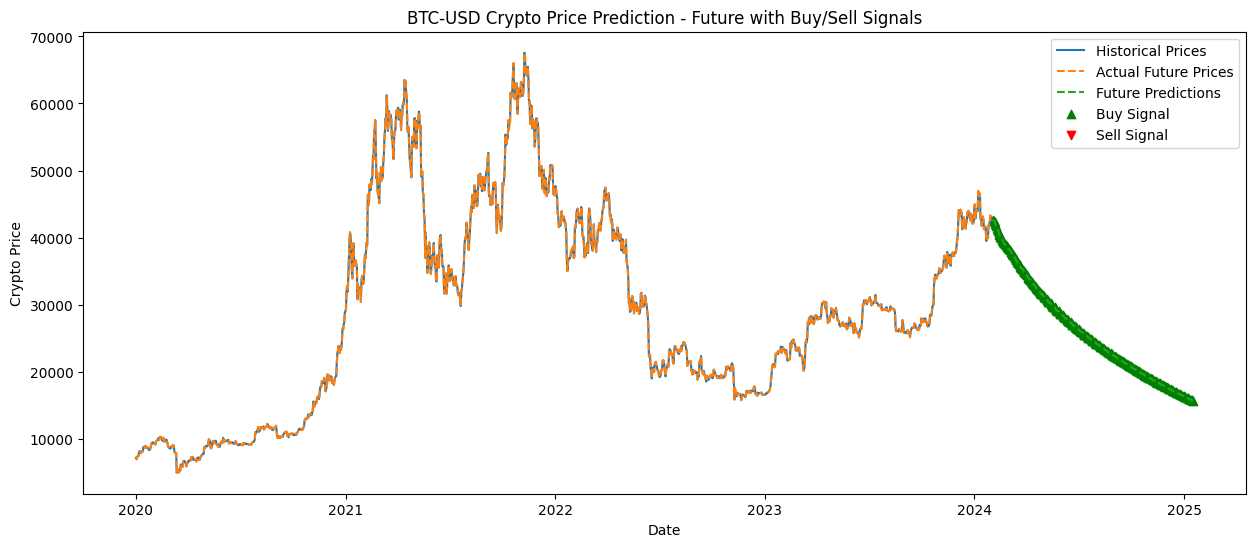

In [42]:
# Generate buy/sell signals based on future predictions
buy_threshold = 1.2  # Example threshold for a buy signal
sell_threshold = 0.8  # Example threshold for a sell signal

# Identify buy signals
buy_signals = np.where(future_predictions > buy_threshold, 1, 0)

# Identify sell signals
sell_signals = np.where(future_predictions < sell_threshold, -1, 0)

# Combine buy and sell signals
combined_signals = buy_signals + sell_signals

# Plot future predictions along with signals
plt.figure(figsize=(15, 6))
plt.plot(crypto_data.index, closing_prices, label='Historical Prices')
plt.plot(crypto_data_future.index, closing_prices_future, label='Actual Future Prices', linestyle='dashed')
plt.plot(pd.date_range(start=crypto_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:], future_predictions, label='Future Predictions', linestyle='dashed')

# Plot buy signals (green) and sell signals (red)
buy_indices = np.where(combined_signals == 1)[0]  # Indices where buy signals are present
sell_indices = np.where(combined_signals == -1)[0]  # Indices where sell signals are present

plt.scatter(pd.date_range(start=crypto_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:][buy_indices], future_predictions[buy_indices], marker='^', color='g', label='Buy Signal')
plt.scatter(pd.date_range(start=crypto_data_future.index[-1], periods=future_time_steps + 1, freq='B')[1:][sell_indices], future_predictions[sell_indices], marker='v', color='r', label='Sell Signal')

plt.title(f'{crypto_symbol} Crypto Price Prediction - Future with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Crypto Price')
plt.legend()
plt.show()